# TSFEL predicting Normal Vs. Pathological knee

To perform this example every cell must be executed. To do so click run ([  ]) in the top left of every cell.

The first step consists of importing TSFEL library. To do so press play. 

The import can take few seconds, but the run button will change so that you know that the import has started and ended.

A warning will appear to reset all runtimes before running, click to accept.

In [1]:
#@title Import Time Series Feature Extraction Library
import warnings
warnings.filterwarnings('ignore')
!pip install https://github.com/fraunhoferportugal/tsfel/archive/v0.1.3.tar.gz
!pip install pandas_profiling
!pip install rarfile
!pip install unrar
!wget http://archive.ics.uci.edu/ml/machine-learning-databases/00278/SEMG_DB1.rar

     | 317kB 277kB/s
  Created wheel for tsfel: filename=tsfel-0.1.3.dev0-cp36-none-any.whl size=42855 sha256=1a83ce55d3037e3deac9f6a11508da587538de91b9b0df48f267cd208dbfef64
  Stored in directory: /tmp/pip-ephem-wheel-cache-yklo2qf5/wheels/ba/e4/52/0149a4f3318dd91b619eabe0329c70e9957ba933888f1fdb36
Successfully built tsfel
  Found existing installation: gspread 3.0.1
    Uninstalling gspread-3.0.1:
      Successfully uninstalled gspread-3.0.1
     |████████████████████████████████| 122kB 2.8MB/s 
  Created wheel for rarfile: filename=rarfile-3.1-cp36-none-any.whl size=24908 sha256=a34f2935a7b8401eb39f44e9c4f9ad7f223161bd94829a8a927ed972a452d1f6
  Stored in directory: /root/.cache/pip/wheels/23/3c/c8/0215b6a5079492eff3be3f545ae0b0c4a66734c35c9e444eac
Successfully built rarfile
--2020-04-13 11:31:03--  http://archive.ics.uci.edu/ml/machine-learning-databases/00278/SEMG_DB1.rar
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archiv

In [0]:
# Import libraries
import glob
import rarfile
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.interpolate as interp
import tsfel
from sklearn import preprocessing
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier

# Unzip dataset
rar_path = rarfile.RarFile("SEMG_DB1.rar", 'r')
rar_path.extractall()
rar_path.close()

### Data pre-processing###
Method to interpolate each file data (EMG and goniometer signals) to the same sample size.

In [0]:
def preprocess(data):
    """Interpolating the EMG and goniometer to the same sample size

      Parameters
      ----------
      data list of pandas DataFrame
        EMG and gonomioter signals for a given activity
      Returns
      -------
        Interpolated data (list of nd-array)

    """
    data = [interp.interp1d(np.arange(len(x[0].dropna())), x[0].dropna(), axis=0, kind='nearest')(np.linspace(0, len(x[0].dropna()) - 1, len(x[0].iloc[:, 0].dropna()))) for x in data]
    return data

## Dataset

The dataset was acquired by Batallón de sanidad (BASAN) in collaboration with the Universidad Militar Nueva Granada – Bogotá. The protocol was performed by 22 male subjects, 11 with different knee abnormalities previously diagnosed by a professional and other 11 without any known knee pathology. The participants were required to perform 3 different exercises: (1) **walk**, (2) **extension of the leg from the sit position** and (3) **flexion of the knee stand up**.

The acquisition process was conducted with 4 electrodes placed on the following muscles (vastus internus, semitendinosus, biceps femoris and rectus femoris) and a goniometer in the knee.

 
**For this example, we will only be using files from the (2) activity and data from rectus femoris muscle and from the goniometer sensor. The classifier will predict if the participant has a normal or pathological knee.**

In [0]:
# @title Loading normal and pathological files from extension of the leg from the sit position
normal_files = glob.glob("N_TXT/*.txt")
patholo_files = glob.glob("A_TXT/*.txt")

normalfl = [[pd.read_csv(fl, sep='\t', skiprows=7, usecols=(0, 4), header=None).dropna()] for fl in
            normal_files if
            'Npie' in fl]

patholofl = [[pd.read_csv(fl, sep='\t', skiprows=7, usecols=(0, 4), header=None).dropna()] for fl in
             patholo_files if 'Apie' in fl]

In [0]:
# @title Train and test set
# dataset sampling frequency, according to dataset information
fs = 1000
# window size for window splitter method (each window has 1 seconds)
window_size = 1000 

# Interpolating data
normalfl = preprocess(normalfl)
patholofl = preprocess(patholofl)

# Dividing into train and test sets. Splitting signal in windows
# Using 2 normal files and 2 pathological files for test set
x_train = list(itertools.chain(*[tsfel.signal_window_spliter(signal[i], window_size, overlap=0) for signal in
                                 [normalfl, patholofl] for i in range(len(normalfl) - 2)]))

x_test = list(itertools.chain(*[tsfel.signal_window_spliter(signal[i], window_size, overlap=0) for signal in
                                [normalfl, patholofl] for i in [len(normalfl) - 2, len(normalfl) - 1]]))

y_train = np.concatenate(
    (np.repeat(0, np.cumsum([int(len(normalfl[i]) / window_size) for i in range(len(normalfl) - 2)])[-1]),
     np.repeat(1, np.cumsum([int(len(patholofl[i]) / window_size) for i in range(len(patholofl) - 2)])[-1])))

y_test = np.concatenate((np.repeat(0, np.cumsum([int(len(normalfl[i]) / window_size) for i in [len(normalfl) - 2, len(normalfl) - 1]])[-1]),
                         np.repeat(1, np.cumsum([int(len(patholofl[i]) / window_size) for i in [len(patholofl) - 2, len(patholofl) - 1]])[-1])))



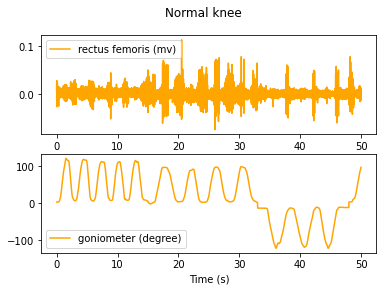

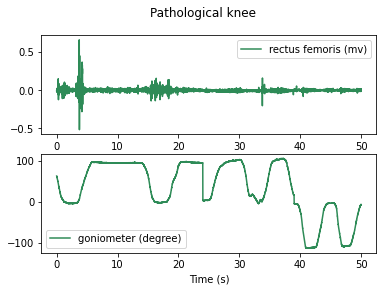

In [6]:
# @title Visualizing signals
nsignal = np.concatenate(x_train[:50])
asignal = np.concatenate(x_train[-50:])
time = np.linspace(0, len(nsignal)* 1/fs, len(nsignal))
c = ['orange', 'seagreen']
title = ['Normal knee', 'Pathological knee']

for i, signal in enumerate([nsignal, asignal]):
    plt.figure(i)
    plt.subplot(211)
    plt.plot(time, signal[:, 0], color=c[i], label='rectus femoris (mv)')
    plt.legend()
    plt.subplot(212)
    plt.plot(time, signal[:, 1], color=c[i], label='goniometer (degree)')
    plt.legend()
    plt.suptitle(title[i])

    plt.xlabel("Time (s)")

In [7]:
# Extract all features' domains (spectral, statistical and temporal)
cfg_file = tsfel.get_features_by_domain()
X_train = tsfel.time_series_features_extractor(cfg_file, x_train, fs=fs)
X_test = tsfel.time_series_features_extractor(cfg_file, x_test, fs=fs)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


In [0]:
# @title Handling eventual missing values from the feature extraction
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train.fillna(X_train.mean(), inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.fillna(X_test.mean(), inplace=True)

In [9]:
# @title Removal of highly correlated features
corr_features = tsfel.correlated_features(X_train)
print('Highly correlated features: ' + '; '.join(corr_features))
X_train = X_train.copy()
X_test = X_test.copy()
for rej in corr_features:
    X_train = X_train.drop(rej, axis=1)
    X_test = X_test.drop(rej, axis=1)

Highly correlated features: 0_FFT mean coefficient_7; 0_FFT mean coefficient_8; 0_FFT mean coefficient_9; 0_FFT mean coefficient_10; 0_FFT mean coefficient_11; 0_FFT mean coefficient_19; 0_FFT mean coefficient_20; 0_FFT mean coefficient_21; 0_FFT mean coefficient_59; 0_FFT mean coefficient_67; 0_FFT mean coefficient_81; 0_FFT mean coefficient_118; 0_FFT mean coefficient_173; 1_FFT mean coefficient_2; 1_FFT mean coefficient_3; 1_FFT mean coefficient_4; 1_FFT mean coefficient_5; 1_FFT mean coefficient_6; 1_FFT mean coefficient_7; 1_FFT mean coefficient_8; 1_FFT mean coefficient_9; 1_FFT mean coefficient_10; 1_FFT mean coefficient_14; 1_FFT mean coefficient_15; 1_FFT mean coefficient_16; 1_FFT mean coefficient_17; 0_LPCC_7; 0_LPCC_8; 0_LPCC_9; 0_LPCC_10; 0_LPCC_11; 1_LPCC_7; 1_LPCC_8; 1_LPCC_9; 1_LPCC_10; 1_LPCC_11; 0_Spectral centroid; 0_Spectral roll-off; 1_Spectral roll-off; 0_Spectral skewness; 1_Spectral skewness; 0_Spectral slope; 1_Spectral slope; 1_Spectral spread; 0_Wavelet absol

In [0]:
# @title Remove constant features
ids_const_features = np.where(np.sum(np.diff(X_train, axis = 0), axis = 0) == 0)[0]

X_train = X_train.drop(X_train.columns[ids_const_features], axis = 1)
X_test = X_test.drop(X_test.columns[ids_const_features], axis = 1)

In [0]:
#@title Normalising Features
min_max_scaler = preprocessing.StandardScaler()
nX_train = pd.DataFrame(min_max_scaler.fit_transform(X_train.values), columns=X_train.columns, index=X_train.index)
nX_test = pd.DataFrame(min_max_scaler.transform(X_test.values), columns=X_test.columns, index=X_test.index)

### Using Decision Tree classifier

In [12]:
classifier = DecisionTreeClassifier()

# Train the classifier
classifier.fit(nX_train, y_train.ravel())

# Predict on test data
y_predict = classifier.predict(nX_test)

condition_labels = ['Normal', 'Pathological']

# Get the classification report
accuracy = accuracy_score(y_test, y_predict) * 100
print(classification_report(y_test, y_predict, target_names = condition_labels))
print("Accuracy: " + str(accuracy) + '%')

              precision    recall  f1-score   support

      Normal       0.90      1.00      0.95        28
Pathological       1.00      0.89      0.94        28

    accuracy                           0.95        56
   macro avg       0.95      0.95      0.95        56
weighted avg       0.95      0.95      0.95        56

Accuracy: 94.64285714285714%


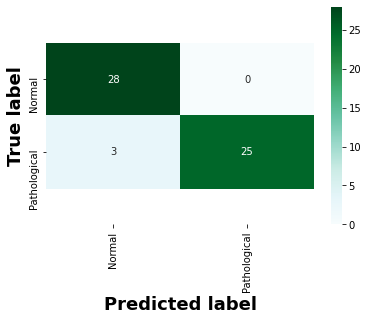

In [13]:
#@title Confusion Matrix
cm = confusion_matrix(y_test, y_predict)
df_cm = pd.DataFrame(cm, index=[i for i in condition_labels], columns = [i for i in condition_labels])
plt.figure()
ax = sns.heatmap(df_cm, cbar = True, cmap="BuGn", annot = True, fmt = 'd')
plt.setp(ax.get_xticklabels(), rotation = 90)
plt.ylabel('True label', fontweight = 'bold', fontsize = 18)
plt.xlabel('Predicted label', fontweight = 'bold', fontsize = 18)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

All features domains were used in the feature extraction step. Accordingly, the Decision Tree classifier obtained high accuracy and was able to distinguish between normal and pathological knee condition during the extension of the leg from the sit position activity.